# Bridge Abutment

In [1]:
# Library Dependencies
%load_ext autoreload
%autoreload 2
import pyec7
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt

## Geomety

In [2]:
# Abutment Geometry
toe_thickness = 1.50 # at the edge
toe_width = 1.65
toe_inclination = 0 # compared to horizontal (degrees)
stemwall_thickness = 1.20  # at the base
stemwall_height_front = 3.30
stemwall_height_rear = 0.50
stemwall_inclination_front = 0 # compared to vertical (degrees)
stemwall_inclination_rear = 0 # compared to vertical (degrees)
bearing_shelf = 2.00
backwall_thickness = 0.50
backwall_height_front = 2.20
backwall_height_rear = 2.50
heel_thickness = 1.50 # at the edge
heel_width = 2.65
heel_inclination = 0 # compared to horizontal (degrees)

# Bearing Location
bearing_point = 0.5*stemwall_thickness

# Soil Geometry
toefill_thickness = 0.50 # at the wall
toefill_inclination = 0 # compared to horizontal (degrees)
backfill_inclination = 0 # compared to horizontal (degrees)

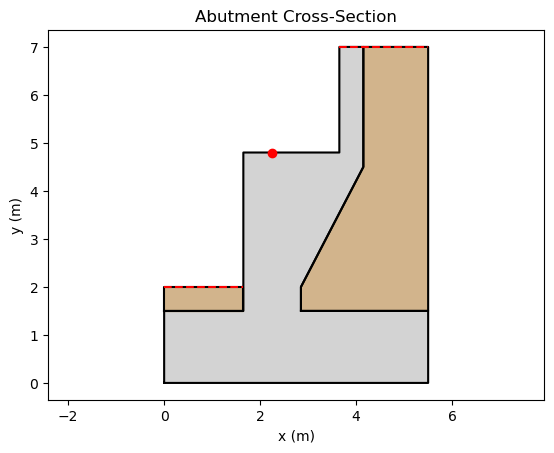

In [3]:
# Geometry computations

# Abutment
footing_width = toe_width + stemwall_thickness + heel_width
wall_dcoord1 = np.array([
    [0, toe_thickness],
    [toe_width, toe_width*np.tan(np.deg2rad(toe_inclination))],
    [stemwall_height_front*np.tan(np.deg2rad(stemwall_inclination_front)), stemwall_height_front],
    [bearing_shelf, 0],
    [0, backwall_height_front],
    [backwall_thickness, backwall_thickness*np.tan(np.deg2rad(backfill_inclination))],
    [0, -backwall_height_rear]
])
wall_dcoord2 = np.array([
    [footing_width, 0],
    [0, heel_thickness],
    [-heel_width, heel_thickness*np.tan(np.deg2rad(heel_inclination))],
    [-stemwall_height_rear*np.tan(np.deg2rad(stemwall_inclination_rear)), stemwall_height_rear]
])
wall_coord = np.vstack([
    [0,0],
    np.cumsum(wall_dcoord1, axis=0),
    np.cumsum(wall_dcoord2, axis=0)[::-1],
    [0,0]
])

# Toe
toefill_dcoord = np.array([
    [0,toe_thickness],
    [toe_width, toe_width*np.tan(np.deg2rad(toe_inclination))],
    [toefill_thickness*np.tan(np.deg2rad(stemwall_inclination_front)), toefill_thickness],
    [-toe_width-toefill_thickness*np.tan(np.deg2rad(stemwall_inclination_front)),
        (toe_width+toefill_thickness*np.tan(np.deg2rad(stemwall_inclination_front)))*np.tan(np.deg2rad(toefill_inclination))],
])
toefill_coord = np.vstack([
    [0,toe_thickness],
    np.cumsum(toefill_dcoord, axis=0)[::-1]
])
toefill_height = toefill_coord[1,1]

# Backfill
backfill_width = footing_width - wall_coord[6,0]
backfill_height = wall_coord[6,1] + backfill_width*np.tan(np.deg2rad(backfill_inclination))
backfill_coord = np.vstack([
    wall_coord[6:10][::-1],
    [footing_width,backfill_height],
    wall_coord[9:11][::-1],
])

# Loads
bearing_coord = wall_coord[3] + [bearing_point,0]
toeload_coord = np.vstack([
    toefill_coord[1],
    toefill_coord[2]
])
backload_coord = np.vstack([
    wall_coord[5],
    backfill_coord[4]
])

# Plot
plt.plot(wall_coord[:,0], wall_coord[:,1], 'k-')
plt.fill(wall_coord[:,0], wall_coord[:,1], color='lightgray')
plt.plot(toefill_coord[:,0], toefill_coord[:,1], 'k-')
plt.fill(toefill_coord[:,0], toefill_coord[:,1], color='tan')
plt.plot(backfill_coord[:,0], backfill_coord[:,1], 'k-')
plt.fill(backfill_coord[:,0], backfill_coord[:,1], color='tan')
plt.plot(bearing_coord[0], bearing_coord[1], 'ro')
plt.plot(toeload_coord[:,0], toeload_coord[:,1], 'r--')
plt.plot(backload_coord[:,0], backload_coord[:,1], 'r--')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Abutment Cross-Section')
plt.show()

# Print
# print("Wall:\n",wall_coord)
# print("\nToe fill:\n",toefill_coord)
# print("\nBackfill:\n",backfill_coord)
# print("\nBearing:\n",bearing_coord)
# print("\nToe load:\n",toeload_coord)
# print("\nBack load:\n",backload_coord)

## Loads

In [4]:
# Safety Factors
gamma_Gu = 1.35
gamma_Qu = 1.50
gamma_Gf = 1.00
gamma_Qf = 0.00
gamma_Rh = 1.10
gamma_Rv = 1.40

In [5]:
# Gravity Loads (kN/m3)
gamma_c = 25
gamma_f = 18

In [6]:
# Surcharges (kN/m2)
q_toe = 2
q_backfill = 5
P_bearing = 1000

In [7]:
# Load computations

# Wall
wall_area = trapz(wall_coord[:,1],wall_coord[:,0])
wall_moment = trapz(wall_coord[:,0]*wall_coord[:,1],wall_coord[:,0])
W_w = gamma_c * wall_area
x_w = wall_moment / wall_area
N_w_d = gamma_Gu * W_w
M_w_d = gamma_Gu * W_w * x_w
N_w_k = gamma_Gf * W_w
M_w_k = gamma_Gf * W_w * x_w

# Toe Fill
toefill_area = trapz(toefill_coord[:,1],toefill_coord[:,0])
toefill_moment = trapz(toefill_coord[:,0]*toefill_coord[:,1],toefill_coord[:,0])
W_tf = gamma_f * toefill_area
x_tf = 0 if W_tf==0 else toefill_moment / toefill_area
N_tf_d = gamma_Gu * W_tf
M_tf_d = gamma_Gu * W_tf * x_tf
N_tf_k = gamma_Gf * W_tf
M_tf_k = gamma_Gf * W_tf * x_tf

# Backfill
backfill_area = trapz(backfill_coord[:,1],backfill_coord[:,0])
backfill_moment = trapz(backfill_coord[:,0]*backfill_coord[:,1],backfill_coord[:,0])
W_bf = gamma_f * backfill_area
x_bf = 0 if W_tf==0 else backfill_moment / backfill_area
N_bf_d = gamma_Gu * W_bf
M_bf_d = gamma_Gu * W_bf * x_bf
N_bf_k = gamma_Gf * W_bf
M_bf_k = gamma_Gf * W_bf * x_bf

# Toe Load
F_tl = q_toe * (toeload_coord[1,0] - toeload_coord[0,0])
x_tl = 0.5 * (toeload_coord[1,0] + toeload_coord[0,0])
N_tl_d = gamma_Qu * F_tl
M_tl_d = 0 if F_tl==0 else gamma_Qu * F_tl * x_tl
N_tl_k = gamma_Qf * F_tl
M_tl_k = 0 if F_tl==0 else gamma_Qf * F_tl * x_tl

# Backfill Load
F_bl = q_backfill * (backload_coord[1,0] - backload_coord[0,0])
x_bl = 0.5 * (backload_coord[1,0] + backload_coord[0,0])
N_bl_d = gamma_Qu * F_bl
M_bl_d = 0 if F_bl==0 else gamma_Qu * F_bl * x_bl
N_bl_k = gamma_Qf * F_bl
M_bl_k = 0 if F_bl==0 else gamma_Qf * F_bl * x_bl

# Bearing Load
P_b = P_bearing
x_b = bearing_coord[0]
N_b_d = 0.5 * (gamma_Gu + gamma_Qu) * P_b
M_b_d = N_b_d * x_b
N_b_k = 0.5 * (gamma_Gf + gamma_Qf) * P_b
M_b_k = N_b_k * x_b

# Print
print("Wall:")
print("W_w = {:.4g} kN/m".format(W_w))
print("N_w,d = {:.4g} kN/m".format(N_w_d))
print("M_w,d = {:.4g} kNm/m".format(M_w_d))
print("N_w,k = {:.4g} kN/m".format(N_w_k))
print("M_w,k = {:.4g} kNm/m".format(M_w_k))
print("x_w = {:.4g} m".format(x_w))
print("\nToe Fill:")
print("W_tf = {:.4g} kN/m".format(W_tf))
print("N_tf,d = {:.4g} kN/m".format(N_tf_d))
print("M_tf,d = {:.4g} kNm/m".format(M_tf_d))
print("N_tf,k = {:.4g} kN/m".format(N_tf_k))
print("M_tf,k = {:.4g} kNm/m".format(M_tf_k))
print("x_tf = {:.4g} m".format(x_tf))
print("\nBackill:")
print("W_bf = {:.4g} kN/m".format(W_bf))
print("N_bf,d = {:.4g} kN/m".format(N_bf_d))
print("M_bf,d = {:.4g} kNm/m".format(M_bf_d))
print("N_bf,k = {:.4g} kN/m".format(N_bf_k))
print("M_bf,k = {:.4g} kNm/m".format(M_bf_k))
print("x_bf = {:.4g} m".format(x_bf))
print("\nToe Load:")
print("F_tl = {:.4g} kN/m".format(F_tl))
print("N_tl,d = {:.4g} kN/m".format(N_tl_d))
print("M_tl,d = {:.4g} kNm/m".format(M_tl_d))
print("N_tl,k = {:.4g} kN/m".format(N_tl_k))
print("M_tl,k = {:.4g} kNm/m".format(M_tl_k))
print("x_tl = {:.4g} m".format(x_tl))
print("\nBackfill Load:")
print("F_bl = {:.4g} kN/m".format(F_bl))
print("N_bl,d = {:.4g} kN/m".format(N_bl_d))
print("M_bl,d = {:.4g} kNm/m".format(M_bl_d))
print("N_bl,k = {:.4g} kN/m".format(N_bl_k))
print("M_bl,k = {:.4g} kNm/m".format(M_bl_k))
print("x_bl = {:.4g} m".format(x_bl))
print("\nBearing Load:")
print("P_b = {:.4g} kN/m".format(P_b))
print("N_b,d = {:.4g} kN/m".format(N_b_d))
print("M_b,d = {:.4g} kNm/m".format(M_b_d))
print("N_b,k = {:.4g} kN/m".format(N_b_k))
print("M_b,k = {:.4g} kNm/m".format(M_b_k))
print("x_b = {:.4g} m".format(x_b))

Wall:
W_w = 383.1 kN/m
N_w,d = 517.2 kN/m
M_w,d = 1414 kNm/m
N_w,k = 383.1 kN/m
M_w,k = 1047 kNm/m
x_w = 2.733 m

Toe Fill:
W_tf = 14.85 kN/m
N_tf,d = 20.05 kN/m
M_tf,d = 16.54 kNm/m
N_tf,k = 14.85 kN/m
M_tf,k = 12.25 kNm/m
x_tf = 0.825 m

Backill:
W_bf = 174.6 kN/m
N_bf,d = 235.7 kN/m
M_bf,d = 1090 kNm/m
N_bf,k = 174.6 kN/m
M_bf,k = 807.2 kNm/m
x_bf = 4.623 m

Toe Load:
F_tl = 3.3 kN/m
N_tl,d = 4.95 kN/m
M_tl,d = 4.084 kNm/m
N_tl,k = 0 kN/m
M_tl,k = 0 kNm/m
x_tl = 0.825 m

Backfill Load:
F_bl = 9.25 kN/m
N_bl,d = 13.88 kN/m
M_bl,d = 63.48 kNm/m
N_bl,k = 0 kN/m
M_bl,k = 0 kNm/m
x_bl = 4.575 m

Bearing Load:
P_b = 1000 kN/m
N_b,d = 1425 kN/m
M_b,d = 3206 kNm/m
N_b,k = 500 kN/m
M_b,k = 1125 kNm/m
x_b = 2.25 m


## Soil Parameters

In [8]:
# Fill
phi_f = 32
coh_f = 0
delta_f = 0

In [9]:
# Subsoil
gamma_s = 20
phi_s = 0
coh_s = 165
delta_s = 30

## Earth Pressures

In [10]:
# Active Earth Pressures
print("Active Pressures:")
Ka = pyec7.earth_pressures( friction=phi_f, cohesion=coh_f,
    delta=delta_f, beta=backfill_inclination, theta=stemwall_inclination_rear, active=True,
    surcharge=q_backfill, inclination=0,
    log=True )

# Coefficient Override
Kag = 0.365
Ka = (Kag, Kag, 2*np.sqrt(Kag), Kag)

# Forces & Moments
E_aq = Ka[1] * q_backfill * backfill_height
y_aq = backfill_height / 2
E_ac = Ka[2] * coh_f * (backfill_height - Ka[2] * coh_f / Ka[3] / gamma_f)
y_ac = (backfill_height - Ka[2] * coh_f / Ka[3] / gamma_f) / 2
E_ag = Ka[3] * 0.5 * gamma_f * backfill_height**2
y_ag = backfill_height / 3

# Total Forces
cos_a = np.cos(np.deg2rad(backfill_inclination + stemwall_inclination_rear + delta_f))
sin_a = np.sin(np.deg2rad(backfill_inclination + stemwall_inclination_rear + delta_f))
E_a_d = gamma_Gu * (E_ac + E_ag) + gamma_Qu * E_aq
H_a_d = E_a_d * cos_a
N_a_d = E_a_d * sin_a
M_ah_d = (gamma_Gu * (E_ac * y_ac + E_ag * y_ag) + gamma_Qu * E_aq * y_aq) * cos_a
M_av_d = (gamma_Gu * (E_ac + E_ag) + gamma_Qu * E_aq) * sin_a * footing_width #why not f?
M_a_d = M_ah_d - M_av_d
y_a = M_ah_d / H_a_d

# Print Results
print("\nResults (factored):")
print("E_a,d =", f"{E_a_d:.4g}", "kN/m")
print("H_a,d =", f"{H_a_d:.4g}", "kN/m")
print("N_a,d =", f"{N_a_d:.4g}", "kN/m")
print("\nM_ah,d =", f"{M_ah_d:.4g}", "kNm/m")
print("M_av,d =", f"{M_av_d:.4g}", "kNm/m")
print("M_a,d =", f"{M_a_d:.4g}", "kNm/m")
print("\ny_a =", f"{y_a:.4g}", "m")

Active Pressures:
Input parameters:
phi = 32 deg
c = 0 kPa
a = 0 kPa
delta = 0 deg
beta = 0 deg
theta = 0 deg
p = 5 kPa

Boundary conditions:
mw = 61 deg
v = 0 deg
mt = 61 deg

Coefficients:
Kn = 0.3073
Kq = 0.3073
Kc = 1.109
Kg = 0.3073

Results (factored):
E_a,d = 236.5 kN/m
H_a,d = 236.5 kN/m
N_a,d = 0 kN/m

M_ah,d = 574.1 kNm/m
M_av,d = 0 kNm/m
M_a,d = 574.1 kNm/m

y_a = 2.428 m


In [11]:
# Passive Earth Pressures
print("Passive Pressures:")
Kp = pyec7.earth_pressures( friction=phi_f, cohesion=coh_f,
    delta=delta_f, beta=toefill_inclination, theta=stemwall_inclination_front, active=False,
    surcharge=q_toe, inclination=0,
    log=True )

# Forces & Moments
E_pq = Ka[1] * q_toe * toefill_height
y_pq = toefill_height / 2
E_pc = Ka[2] * coh_f * (toefill_height - Kp[2] * coh_f / Kp[3] / gamma_f)
y_pc = (toefill_height - Kp[2] * coh_f / Kp[3] / gamma_f) / 2
E_pg = Ka[3] * 0.5 * gamma_f * toefill_height**2
y_pg = toefill_height / 3

# Total Forces
cos_p = np.cos(np.deg2rad(toefill_inclination + stemwall_inclination_front - delta_f))
sin_p = np.sin(np.deg2rad(toefill_inclination + stemwall_inclination_front - delta_f))
E_p_d = gamma_Gf * (E_pc + E_pg) + gamma_Qf * E_pq
H_p_d = E_p_d * cos_p
N_p_d = E_p_d * sin_p
M_p_d = (gamma_Gf * (E_pc * y_pc + E_pg * y_pg) + gamma_Qf * E_pq * y_pq) * cos_p
y_p = M_p_d / H_p_d

# Print Results
print("\nResults (factored):")
print("E_p,d =", f"{E_p_d:.4g}", "kN/m")
print("H_p,d =", f"{H_p_d:.4g}", "kN/m")
print("N_p,d =", f"{N_p_d:.4g}", "kN/m")
print("\nM_p,d =", f"{M_p_d:.4g}", "kNm/m")
print("\ny_p =", f"{y_p:.4g}", "m")

Passive Pressures:
Input parameters:
phi = 32 deg
c = 0 kPa
a = 0 kPa
delta = 0 deg
beta = 0 deg
theta = 0 deg
p = 2 kPa

Boundary conditions:
mw = 29 deg
v = 0 deg
mt = 29 deg

Coefficients:
Kn = 3.255
Kq = 3.255
Kc = 3.608
Kg = 3.255

Results (factored):
E_p,d = 13.14 kN/m
H_p,d = 13.14 kN/m
N_p,d = 0 kN/m

M_p,d = 8.76 kNm/m

y_p = 0.6667 m


## Bearing Resistance

In [12]:
# Total Load Computations

# Vertical
N_d = N_w_d + N_bf_d + N_bl_d + N_tf_d + N_tl_d + N_b_d + N_a_d - N_p_d

# Horizontal
H_d = H_a_d - H_p_d

# Moment (toe)
M_d1 = M_a_d - M_p_d
M_d2t = M_w_d + M_bf_d + M_bl_d + M_tf_d + M_tl_d + M_b_d
x_d2t = M_d2t / N_d
x_d2 = np.abs(footing_width/2 - x_d2t)
M_d2 = N_d * x_d2
M_d = M_d1 - M_d2

print("Total Loads:")
print(f"N_d = {N_d:.2f} kN/m")
print(f"H_d = {H_d:.2f} kN/m")
print(f"M_d = {M_d:.2f} kNm/m")

Total Loads:
N_d = 2216.80 kN/m
H_d = 223.33 kN/m
M_d = 262.79 kNm/m


In [13]:
# Bearing capacity computations
R = pyec7.bearing_resistance( width=footing_width, length=0,
    embedment=toefill_height, inclination=0,
    unit_weight=gamma_s, friction=phi_s, cohesion=coh_s,
    vertical=N_d,
    horizontal=H_d, moment=M_d,
    surcharge=q_toe,
    log=True,)

Geometry:
B = 5.5 m
L = 0 m
D = 2 m
a = 0 deg

Soil Properties:
gamma = 20 kN/m3
phi = 0 deg
c = 165 kPa

Loading:
V = 2217 kN
HB = 223.3 kN
HL = 0 kN
H = 223.3 kN
MB = 262.8 kNm
ML = 0 kNm
q = 42 kPa

Effective Dimensions:
eB = 0.1185 m
eL = 0 m
Be = 5.263 m
Le = 0 m
Ae = 5.263 m2

Bearing Capacity Factors:
Nq = 1
Nc = 5.142
Ng = -0

Inclination Factors:
bq = 1
bc = 1
bg = 1

Shape Factors:
sq = 1
sc = 1
sg = 1

Load Inclination Factors:
iq = 1
ic = 0.9309
ig = 1

Results:
qu = 831.8 kPa
R = 4378 kN


# Design

In [14]:
# Sliding
N_k = N_w_k + N_bf_k + N_bl_k + N_tf_k + N_tl_k
R_h_d = N_k * np.tan(np.deg2rad(delta_s)) / gamma_Rh
FS_h = R_h_d / H_d
print("FS_h = R_h,d / H_d = ", f"{R_h_d:.4g}", "/", f"{H_d:.4g}", "=", f"{FS_h:.4g}")

FS_h = R_h,d / H_d =  300.5 / 223.3 = 1.346


In [15]:
# Bearing Capacity
R_v_d = R / gamma_Rv
FS_v = R_v_d / N_d
print("FS_v = R_v,d / N_d = ", f"{R_v_d:.4g}", "/", f"{N_d:.4g}", "=", f"{FS_v:.4g}")

FS_v = R_v,d / N_d =  3127 / 2217 = 1.411


## Stiffness

In [16]:
# Soil Properties
su = coh_s
Gmax = 1500 * su
G = (2/3) * Gmax
g = 9.81
rho = gamma_s/g
Vs = np.sqrt(G/rho)
nu = 0.45

# Print Soil Properties
print("Soil Properties:")
print("su = {:.4g}".format(su), "kPa")
print("Gmax = {:.4g}".format(Gmax), "kPa")
print("G = {:.4g}".format(G), "kPa")
print("Vs = {:.4g}".format(Vs), "m/s")
print("nu = {:.4g}".format(nu))

Soil Properties:
su = 165 kPa
Gmax = 2.475e+05 kPa
G = 1.65e+05 kPa
Vs = 284.5 m/s
nu = 0.45


In [17]:
# Footing Properties
B = 0.5 * footing_width
D = toefill_height
d = toe_thickness

# Print footing properties
print("\nFooting Properties:")
print("B = {:.4g}".format(B), "m")
print("D = {:.4g}".format(D), "m")
print("d = {:.4g}".format(d), "m")


Footing Properties:
B = 2.75 m
D = 2 m
d = 1.5 m


In [18]:
# Frequency
f = 0
omega = 2 * np.pi * f
ao = omega*B/Vs

# Print frequency
print("\nVibration Frequency:")
print("f = {:.4g}".format(f), "Hz")
print("ao = {:.4g}".format(ao))


Vibration Frequency:
f = 0 Hz
ao = 0


In [19]:
# Rotational Stiffness

# Surface
Krx_surf = (np.pi/2) * G*B**2 / (1-nu) # Gazetas (1991) - Table 15.3
# The above coefficient is 1.57, compared to 1.49 in Table 15.1, and 1.60 in Pais & Kausel (1988)

# Embedment Depth Correction Factor
krx_embed = 1 + 1.26 * d/B # Gazertas (1991) - Table 15.2
# The above coefficient in Pais & Kausel (1988) is 1.0, but D/B is used.

# Dynamic Stiffness Coefficient
krx_dyn = 1-0.2*ao # Gazetas (1991) - Table 15.1

# Dynamic Stiffness
Krx_dyn = krx_embed * krx_dyn * Krx_surf

# Print
print("Rotational Stiffness:")
print("Krx_surf = ", f"{Krx_surf:.4g}", "kNm/m/rad")
print("krx_embed = ", f"{krx_embed:.4g}")
print("krx_dyn = ", f"{krx_dyn:.4g}")
print("Krx_dyn = ", f"{Krx_dyn:.4g}", "kNm/m/rad")

Rotational Stiffness:
Krx_surf =  3.564e+06 kNm/m/rad
krx_embed =  1.687
krx_dyn =  1
Krx_dyn =  6.013e+06 kNm/m/rad
